In [1]:
import os
import pandas as pd

import numpy as np
import librosa
import soundfile as sf
from itertools import product
import resampy
import shutil

import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

import tensorflow as tf
import sklearn as skl
from sklearn.naive_bayes import GaussianNB
import torch
import fairseq
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
# import onnx
# from onnx_tf.backend import prepare

Paths

In [2]:
path_id = 'LibriSpeech/dev-clean/'  # percorso del dataaset iniziale dove sono contenuti gli speaker id
path_dataset = 'audio_dataset/'  # percorso del dataset creato per ottimizzare la lettura dei file -------
path_speakers = 'LibriSpeech/SPEAKERS.TXT'  # percorso al file degli speaker
path_files = 'audio_files/'  # percorso degli audio file divisi per speaker
path_mfccs = 'mfccs_seq/'  # percorso degli mfccs applicati ai file audio senza modificarne la lunghezza, divisi per speaker id
path_mfccs_cut = 'mfccs_seq_cut/'  # percorso mfccs applicati a file audio di 1.42 secondi, divisi per speaker id
path_audio_2sec = 'audio_files_2sec'  # percorso mfccs applicati a file audio di 2 secondi, divisi per speaker id

In [3]:
names = ['Ids', 'Sex', 'Subset', 'Minutes', 'Name']  # etichette delle colonne della tabella contenente le caratteristiche degli speaker
table = pd.read_csv(path_speakers,sep='|', comment=";", header=None, names=names) # creazione tabella da lettura file txt con caratteristiche degli speaker attraverso pandas
ids_col = pd.DataFrame(map(int,os.listdir(path_id)), columns=['Ids'], dtype='int64')  # creazione di tabella-colonna corrispondente alla lista degli speaker nel dataset considerato
speaker_table = pd.merge(ids_col, table, on='Ids', how='inner').sort_values(by=['Ids'])  # join delle due tabelle in modo da avere solo i dati corrispondeti agli speaker nel nostro dataset
speaker_table = speaker_table.set_index(['Ids'])  # sostituzione indici della tabella con gli Id degli speaker

Creazione cartella con dati divisi per speaker_id

In [6]:
""" Cicli for annidati per copiare i file in una cartella unica separata, in modo che l'accesso sia successivamente più semplice
    nelle fasi di training e testing"""
for ids in os.listdir(path_id):  # scorrimento degli speaker nella prima cartella
    path = os.path.join(path_files, ids) # path dove andrò a copiare i file
    os.makedirs(path, exist_ok=True) # creazione della cartella se non già presente
    for ch in os.listdir(f'{path_id}{ids}/'):  # scorrimento dei chapters per ogni speaker 
        for file in os.listdir(f'{path_id}{ids}/{ch}/'):  # scorrimento dei file all'interno di ogni cartella di chapter
            if '.trans' in file:  # passaggio per ignorare il file txt con la trascrizione dei file audio
                continue
            shutil.copy(f'{path_id}{ids}/{ch}/{file}', f'{path_files}{ids}/{file}')  #copia dei file dal dataset originale nel nuovo percorso
        

Creazione cartella con mfccs dei file audio non modificati divisi per speaker_id

In [7]:
""" Cicli for annidati per copiare i file in una cartella unica separata, in modo che l'accesso sia successivamente più semplice
    nelle fasi di training e testing"""
for ids in os.listdir(path_id):  # scorrimento degli speaker nella prima cartella
    path = os.path.join(path_mfccs, ids)  # percorso in cui verranno salvati i file audio
    old_path = os.path.join(path_files, ids)  # percorso da cui vengono caricati i file audio
    os.makedirs(path, exist_ok=True)  # creazione della cartella di destinazione se non già presente
    for file in os.listdir(old_path):  # scorrimento dei file all'interno di ogni cartella di id
        file_name = file.split('.')[0]  # rimozione dal nome di ogni file della parte ".flac" sostituita con il formato ".npy"
        data, sr = sf.read(f'{old_path}/{file}')  # caricamento dei file audio
        if sr != 16000:
            print('Need for resample') # check della frequenza di campionamento di tutti i file audio
        mfccs = librosa.feature.mfcc(data, sr=sr)  # estrazione delle mfcc features
        np.save(f'{path}/{file_name}.npy',mfccs)  # salvataggio dei mfccs nella cartella di destinazione
        

Creazione cartella dei file audio tagliati a 2 secondi (con aggiunta di zeri dove minori di 2s) divisi per speaker_id

In [17]:
""" Cicli for annidati per copiare i file in una cartella unica separata, in modo che l'accesso sia successivamente più semplice
    nelle fasi di training e testing"""
for ids in os.listdir(path_id):  # scorrimento degli speaker nella prima cartella
    path = os.path.join(path_audio_2sec, ids)
    old_path = os.path.join(path_files, ids)
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(old_path):  # scorrimento dei file all'interno di ogni cartella di id
        file_name = file.split('.')[0]
        data, sr = sf.read(f'{old_path}/{file}')
        if len(data)/sr < 2.0:  # se il file audio è più corto di 2 secondi vengono aggiunti 0 alla fine per avere array della stessa lunghezza
            data = np.append(data, np.zeros(2*sr-len(data)), 0)
        else:
            data = data[:2*sr]
        sf.write(f'{path}/{file_name}.flac',data,sr)
#     print(len(os.listdir(path)))
        

In [ ]:
""" Audio tagliati tutti a 1.42 per fare in modo che siano tutti lunghi uguali senza riempire quelli più corti con zeri.
Fare questa specie di zero padding  causerebbe delle modifiche alla distribuzione delle mfcc features e temo potrebbe
influenzare la classificazione."""
for ids in os.listdir(path_id):  # scorrimento degli speaker nella prima cartella
    path = os.path.join('mfccs_seq_cut/', ids)
    old_path = os.path.join(path_files, ids)
    print(path, old_path)
    os.makedirs(path, exist_ok=True)
    for file in os.listdir(old_path):  # scorrimento dei file all'interno di ogni cartella di id
        file_name = file.split('.')[0]  # rimozione dal nome di ogni file della parte ".flac" sostituita con il formato ".npy"
        data, sr = sf.read(f'{old_path}/{file}')
#     Prendiamo la finestra centrale per avere maggiore sicurezza di non avere silenzio
        window_length = int(1.42 * sr)
        w_start = int(np.floor(len(data)/2) - window_length/2)
        w_stop = int(np.floor(len(data)/2) + window_length/2)
        data = data[w_start:w_stop]
        
        mfccs = librosa.feature.mfcc(data, sr=sr) # calcolo dei mfccs
        np.save(f'{path}/{file_name}.npy',mfccs) # salvataggio
        

1272-128104-0013.flac
6.0
numero frame 600.0 600.0
16000
[[-5.96101450e+02 -5.87396956e+02 -5.74160277e+02 ... -4.23111582e+02
  -4.84774836e+02 -5.41884895e+02]
 [ 5.15323343e+01  6.08858640e+01  7.28648786e+01 ...  1.39910656e+02
   7.66339606e+01  4.53918074e+01]
 [ 2.23107391e+01  2.44106468e+01  2.66255252e+01 ...  1.77750071e+01
   2.56113496e-01  9.47906482e+00]
 ...
 [ 5.21517114e+00  6.95585602e+00  5.69997241e+00 ...  7.38047173e+00
   1.28123962e+01  9.77946204e+00]
 [ 2.16461467e+00  4.23869599e+00  5.40869221e+00 ... -5.84107808e+00
  -5.46139426e+00 -6.91449737e+00]
 [-1.88547721e-01 -5.70121117e-02  9.54867625e-01 ...  2.16593335e+00
   2.84665966e-01 -1.89794213e+00]]
264600
[ 0.00069069  0.00079111  0.00071959 ... -0.00071187 -0.00053224
 -0.00026465]
(20, 517) 20


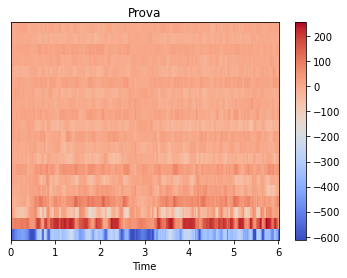

In [21]:
# for file in os.listdir(path_dataset)[:3]:
file = os.listdir(path_dataset)[13]
print(file)
data, sr = sf.read(f'{path_dataset}{file}')
data = data[:6*sr]
print(len(data)/sr)
t = 0.010
hop_length = int(np.ceil(t * sr))
print(f'numero frame {len(data)/hop_length} {(len(data)/sr)/t}')
# t = np.arange(0,len(data)/sr,1/sr)
# plt.plot(t, data)
# plt.show()
print(sr)
data = resampy.resample(data, sr, 44100)
sr = 44100
# mfcc = librosa.feature.mfcc(data, sr=sr, hop_length=hop_length)
mfcc = librosa.feature.mfcc(data, sr=sr)
print(mfcc)
# librosa.display.specshow(mfcc, sr=sr, x_axis='time')
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True) #  , figsize=(50,10))
img = librosa.display.specshow(mfcc, sr=sr, x_axis='time')
ax.set(title='Prova')
fig.colorbar(img)


print(len(data))
print(data)
print(np.shape(mfcc), len(mfcc))
# t = hop_length / sr 

# plt.imshow(mfcc)
# plt.colorbar()
# plt.show()



In [16]:
# fft_length = 2 ** int(np.ceil(np.log(int(0.025*16000)) / np.log(2.0)))
# hop_length_samples = int(round(16000 * 0.010))
# X_lr = np.abs(librosa.stft(
#         data,
#         window='hann',
#         n_fft=fft_length,
#         hop_length=hop_length_samples,
#         win_length=int(0.025*16000))
#     )
# mfcc1 = librosa.feature.mfcc(X_lr)

# fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(50,10))
# img = librosa.display.specshow(mfcc1, x_axis='time')
# ax.set(title='Prova')
# fig.colorbar(img)

In [91]:
ipd.Audio(data, rate=sr)

1272-128104-0013.flac
7.1
numero frame 710.0 710.0


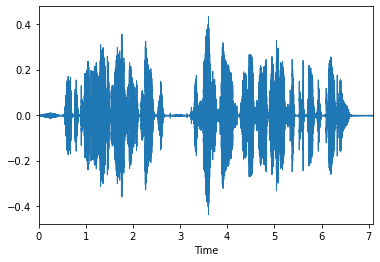

In [32]:
# for file in os.listdir(path_dataset)[:3]:
file = os.listdir(path_dataset)[13]
print(file)
data, sr = sf.read(f'{path_dataset}{file}')
# data = data[:6*sr]
print(len(data)/sr)
t = 0.010
hop_length = int(np.ceil(t * sr))
print(f'numero frame {len(data)/hop_length} {(len(data)/sr)/t}')

librosa.display.waveplot(data, sr)

# t = np.arange(0,len(data)/sr,1/sr)
# plt.plot(t, data)
# plt.show()
# print(samplerate)


In [ ]:

# mfcc = librosa.feature.mfcc(data, sr=sr, hop_length=hop_length)
mfcc = librosa.feature.mfcc(data, sr=sr)
# print(mfcc)
# librosa.display.specshow(mfcc, sr=sr, x_axis='time')
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True) #  , figsize=(50,10))
img = librosa.display.specshow(mfcc, sr=sr, x_axis='time', clim=[-550,250])
ax.set(title='Prova')
fig.colorbar(img)



print(len(data))
print(data)
print(np.shape(mfcc), len(mfcc))
# t = hop_length / sr 

# plt.imshow(mfcc)
# plt.colorbar()
# plt.show()

In [ ]:
print(mfcc)
mfcc = skl.preprocessing.scale(mfcc, axis=1)
print(f'\n{mfcc}')
print(mfcc.mean(axis=1))
print(mfcc.var(axis=1))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

Data Analysis

In [37]:
# Prendiamo 4 file (2 con etichetta M e 2 F) dalla cartella con le mfcc features per analizzarli
data_analysis_array = []
considered_ids = [2277,2412,2428,2803]
for i in considered_ids:
    lista_file = os.listdir(f'{path_mfccs}/{i}')
    np.random.shuffle(lista_file)  # shuffle dell' array per prendere un campione casuale da quelli appartenenti a quello speaker id
    data_analysis_array.append(lista_file[0])
print(data_analysis_array)

['2277-149897-0027.npy', '2412-153947-0012.npy', '2428-83699-0032.npy', '2803-161169-0013.npy']


C:\Users\eleo4\AppData\Local\Temp/ipykernel_13560/3317378370.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

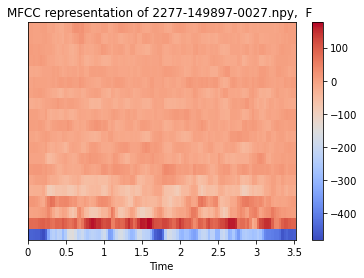

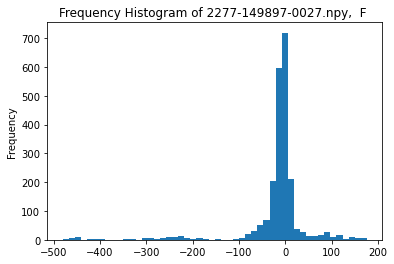

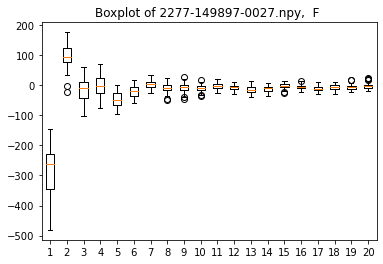

<Figure size 432x288 with 0 Axes>

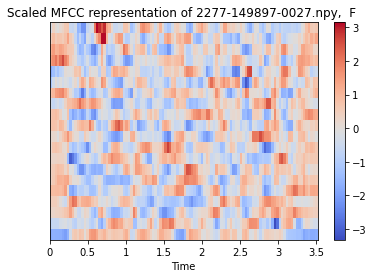

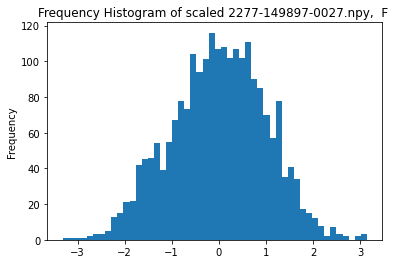

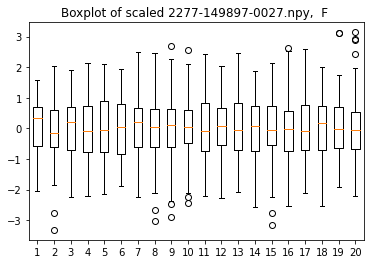

<Figure size 432x288 with 0 Axes>

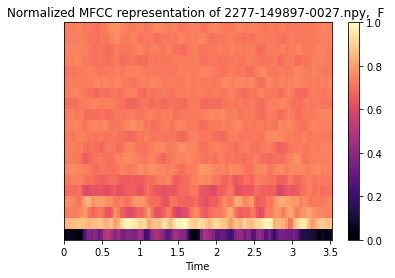

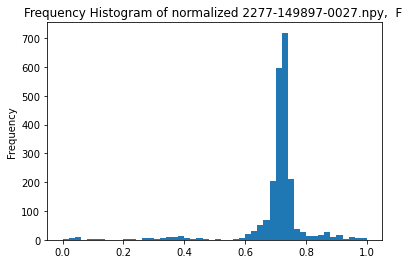

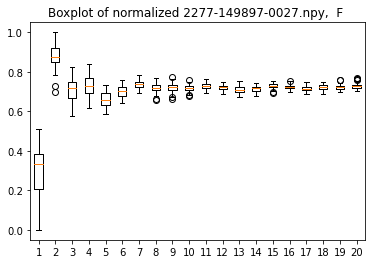

<Figure size 432x288 with 0 Axes>

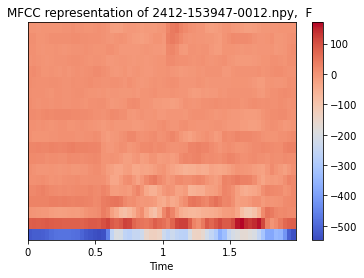

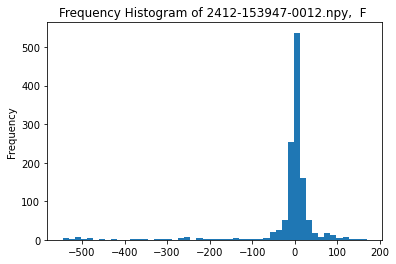

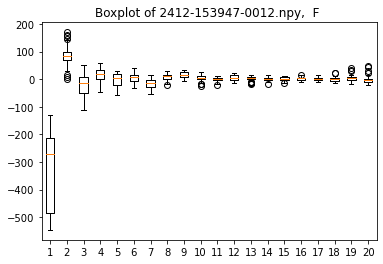

<Figure size 432x288 with 0 Axes>

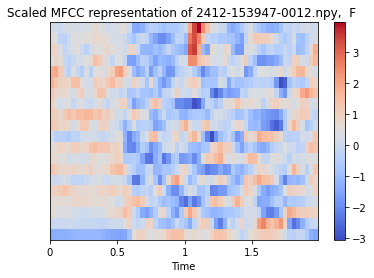

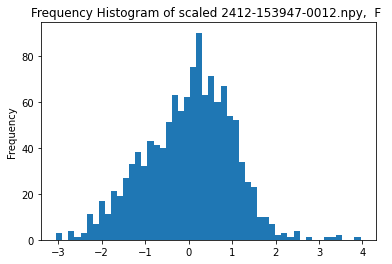

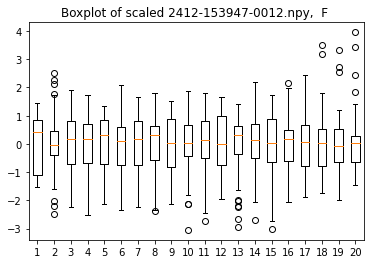

<Figure size 432x288 with 0 Axes>

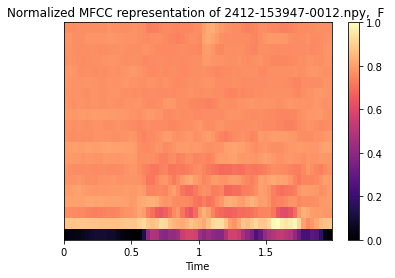

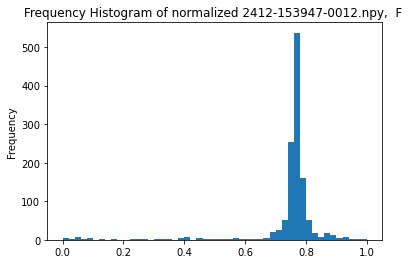

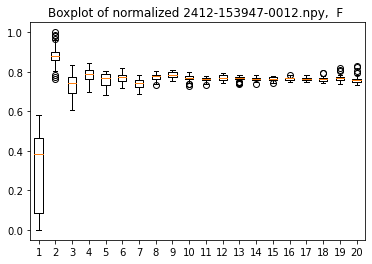

<Figure size 432x288 with 0 Axes>

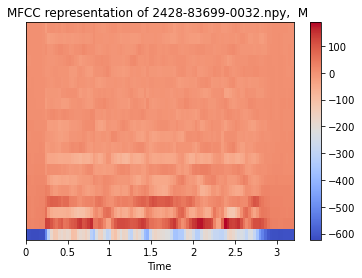

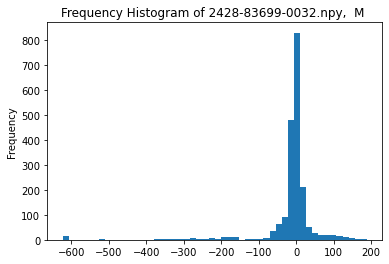

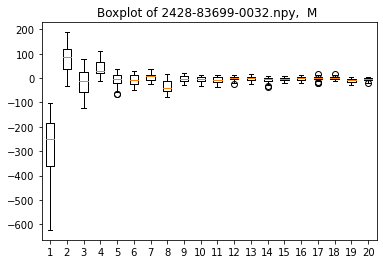

<Figure size 432x288 with 0 Axes>

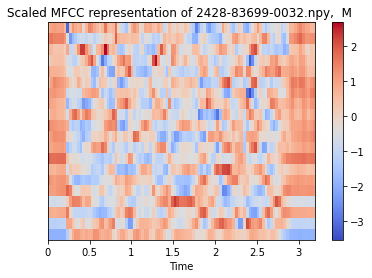

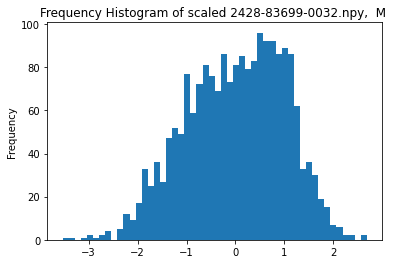

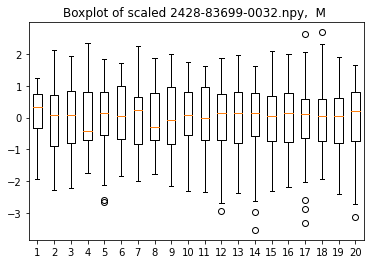

<Figure size 432x288 with 0 Axes>

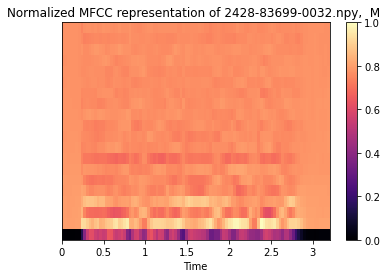

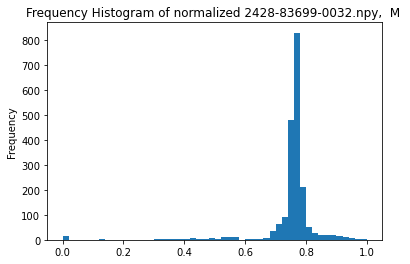

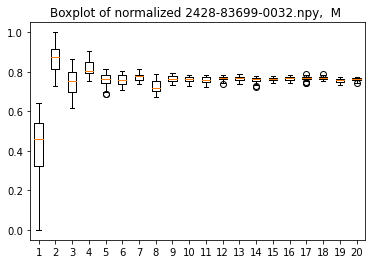

<Figure size 432x288 with 0 Axes>

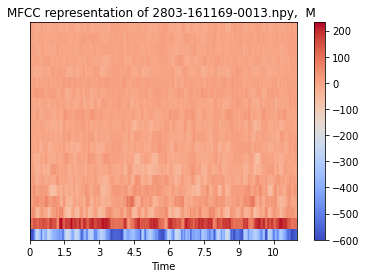

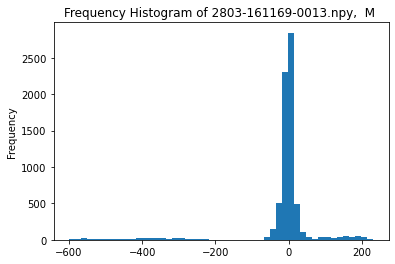

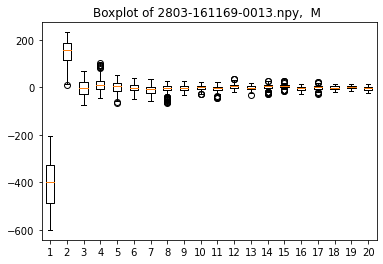

<Figure size 432x288 with 0 Axes>

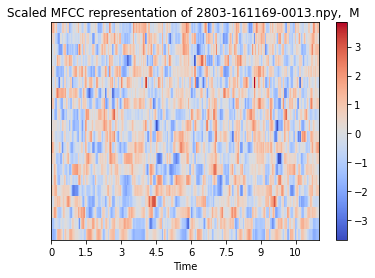

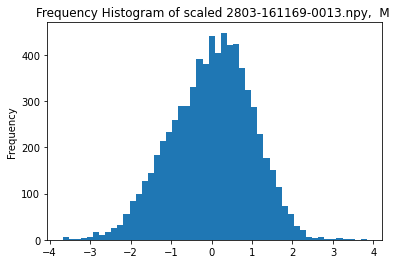

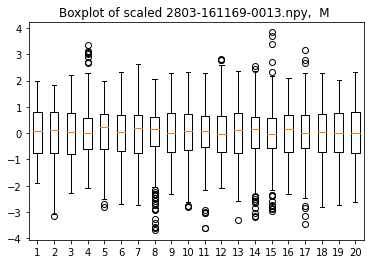

<Figure size 432x288 with 0 Axes>

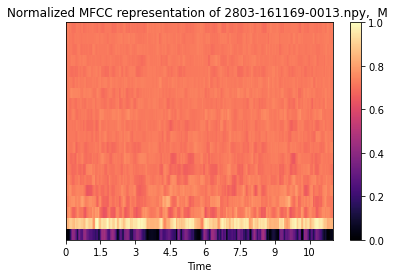

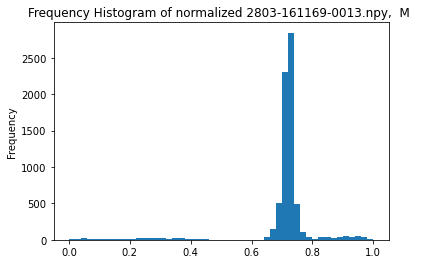

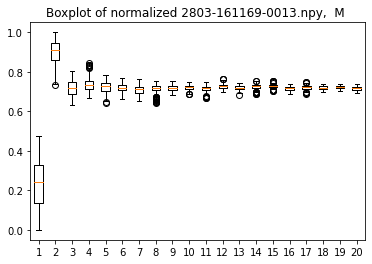

In [38]:
# Salvataggio della lista per fissare i file che visualizziamo.
data_analysis_array = ['2277-149897-0027.npy', '2412-153947-0012.npy', '2428-83699-0032.npy', '2803-161169-0013.npy']

for file in data_analysis_array:
    id_split = int(file.split('-')[0])
    sex = speaker_table.loc[id_split]['Sex']
    
    sr = 16000  # frequenza di campionamento che sappiamo essere uguale per tutti i file audio
    mfcc = np.load(f'{path_mfccs}/{id_split}/{file}')
    
    plt.figure()
    fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
    img = librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    ax.set_title(f'MFCC representation of {file}, {sex}')
    fig.colorbar(img)
    
    plt.figure()
    plt.hist(mfcc.flatten(), bins=50)
    plt.gca().set(title=f'Frequency Histogram of {file}, {sex}', ylabel='Frequency');
    
    
    plt.figure()
    plt.boxplot(np.array(mfcc).T)
    plt.title(f'Boxplot of {file}, {sex}')
    
#     Standardizzazione 
    
    mfcc_scaled = skl.preprocessing.scale(mfcc, axis=1)  # standardizzazione degli mfccs nell'asse dei bins
    
    plt.figure()
    fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
    img = librosa.display.specshow(mfcc_scaled, sr=sr, x_axis='time')
    ax.set_title(f'Scaled MFCC representation of {file}, {sex}')
    fig.colorbar(img)
    
    plt.figure()
    plt.hist(mfcc_scaled.flatten(), bins=50)
    plt.gca().set(title=f'Frequency Histogram of scaled {file}, {sex}', ylabel='Frequency');
    
    
    plt.figure()
    plt.boxplot(np.array(mfcc_scaled).T)
    plt.title(f'Boxplot of scaled {file}, {sex}')
    
#     Normalizzazione

    mfcc_norm = (mfcc - np.array(mfcc).min()) / (np.array(mfcc).max() - np.array(mfcc).min())
    
    plt.figure()
    fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
    img = librosa.display.specshow(mfcc_norm, sr=sr, x_axis='time')
    ax.set_title(f'Normalized MFCC representation of {file}, {sex}')
    fig.colorbar(img)
    
    plt.figure()
    plt.hist(mfcc_norm.flatten(), bins=50)
    plt.gca().set(title=f'Frequency Histogram of normalized {file}, {sex}', ylabel='Frequency');
    
    
    plt.figure()
    plt.boxplot(np.array(mfcc_norm).T)
    plt.title(f'Boxplot of normalized {file}, {sex}')  
    

Qui ora commentiamo le immagini che sono state riprodotte.

Dalle rappresentazioni dei mfccs non si notano differenze particolari tra campioni con etichetta M e con etichetta F.
Gli istogrammi mostrano degli outliers nei valori minori di -400. Ciò avviene con tutti i campioni.
La differenza tra gli istogrammi maschili e femminili è soprattutto nella quantità del bin più frequente. Ciò però è dovuto soprattuto al fatto che i file audio hanno lunghezze diverse.

Successivamente è stata effettuata una standardizzazione delle features sull'asse dei bin. 
Le rappresentazione delle scaled mfcc features non mostrano particolari differenze che aiutino con il discernimento tra M e F.
La standardizzazione porta ad una distibuzione lungo l'asse x dell'istogramma, trasformando l'andamento dei valori in una curva quasi gaussiana per tutti gli esperimenti presi in visione.

Il terzo gruppo di grafici per ogni campione rappresenta una versione normalizzata delle mfcc features, scalate tra 0 e 1.
Le rappresentazioni dei mfccs normalizzati sono identiche a quelle di quelli non modificati, esclusa per i valori assunti che hanno una scala diversa e quindi risultano di un colore diverso, ma sono distribuiti ugualmente.
Gli istogrammi sono non distribuiti come quelli dei mfccs non modificati e sono uguali a questi, con la differenza dell'asse x che ora risulta in una scala da 0 a uno.

Con queste rappresentazioni si sono identificati possibili outliers nei valori minori a -400, però osservandoli non è stato possibile correlarle ad una etichetta o l'altra.

CREAZIONE DATASET DA PARTIZIONARE

In [50]:
X = np.array(os.listdir(path_id)) # salvataggio degli id degli speaker come array
y = []
speaker_table1 = speaker_table
# salvataggio della colonna corrispondente alle etichette, sostituendo M e F con 0 e 1
speaker_table1= speaker_table1['Sex'].replace(' M ', 0).replace(' F ', 1)
for ids in X:
#   creazione dell'array delle etichette nella stessa posizione dei corrispondenti speaker_id
    y.append(speaker_table1.loc[int(ids)])
y = np.array(y)
print(X, y)

['1272' '1462' '1673' '174' '1919' '1988' '1993' '2035' '2078' '2086'
 '2277' '2412' '2428' '251' '2803' '2902' '3000' '3081' '3170' '3536'
 '3576' '3752' '3853' '422' '5338' '5536' '5694' '5895' '6241' '6295'
 '6313' '6319' '6345' '652' '777' '7850' '7976' '8297' '84' '8842'] [0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0
 0 1 1]


In [51]:
'''Utilizzo della funzione train_test_split per dividere il dataset in train e test set.
Questa divisione viene fatta sugli id degli speaker.
La classificazione che si sta eseguendo riguarda il genere degli speaker, pertanto si è deciso
di considerare i loro id come discriminante di cosa la rete può vedere in training e cosa in testing.
In questo modo la rete in fase di testing dovrà cercare di identificare il sesso di uno speaker 
senza "averlo mai sentito parlare".'''
id_train, id_test, y_train_id, y_test_id = skl.model_selection.train_test_split(X, y, test_size=0.20, shuffle=True)
print(id_train, id_test, y_train_id, y_test_id)

['6241' '1919' '2412' '1272' '3576' '3752' '8297' '251' '7850' '5536'
 '3170' '422' '2277' '1988' '652' '6319' '3081' '6345' '777' '5694' '2078'
 '6313' '7976' '5338' '84' '5895' '1462' '6295' '3000' '2803' '1673'
 '2902'] ['2086' '3536' '1993' '2428' '2035' '3853' '174' '8842'] [0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0] [0 1 1 0 1 1 0 1]


In [65]:
# seed = 42
# tf.random.set_seed(seed)

# enumerate splits
# kfold = skl.model_selection.KFold(n_splits=3,shuffle=True,random_state=42)
# for train, test in kfold.split(X):
#     print(f'train: {X[train]}, test: {X[test]}')

'''Caricamento delle mfcc features del train set (data ed etichette) 
in una lista creata scorrendo il contenuto della cartella di ogni speaker
e utilizzando le liste di id e di etichette di train create sopra.'''
X_train = []
y_train = []
for i in range(len(id_train)):
    file_path = f'mfccs_seq_cut/{id_train[i]}/' 
    for file in os.listdir(file_path):
        mfccs = np.load(f'{file_path}/{file}')  # caricamento di ogni npy contenente i mfccs per ogni speaker
        mfccs = skl.preprocessing.scale(mfccs, axis=1)  # standardizzazione sui bin
        X_train.append(mfccs)
        y_train.append(y_train_id[i])  # assegnazione dell'etichetta corrispondente a tutti file dello stesso speaker
        
'''Caricamento delle mfcc features del test set (data ed etichette) 
in una lista creata scorrendo il contenuto della cartella di ogni speaker
e utilizzando le liste di id e di etichette di test create sopra.'''
X_test = []
y_test = []
for i in range(len(id_test)):
    file_path = f'mfccs_seq_cut/{id_test[i]}/'
#     print(file_path)
#     print(len(os.listdir(file_path)))
    for file in os.listdir(file_path):
        mfccs = np.load(f'{file_path}/{file}')   # caricamento di ogni npy contenente i mfccs per ogni speaker
        mfccs = skl.preprocessing.scale(mfccs, axis=1)  # standardizzazione sui bin
        X_test.append(mfccs)
        y_test.append(y_test_id[i]) # assegnazione dell'etichetta corrispondente a tutti file dello stesso speaker

In [66]:
# controllo del bilanciamento del dataset.
'''Dato che gli speaker identificati come M sono circa il 52% e quelli identificati come F sono il 48%,
non è stato adottato nessun tipo di bilanciamento del dataset.'''
val, num = np.unique(y_train, return_counts=True)
print(val)
print(f'Percentuali etichette corrispondenti a  M: {num[0]/sum(num)} %')
print(f'Percentuali etichette corrispondenti a  F: {num[1]/sum(num)} %')

[0 1]
Percentuali etichette corrispondenti a  M: 0.5148334094020995 %
Percentuali etichette corrispondenti a  F: 0.4851665905979005 %


In [67]:
'''Shuffle degli array di data ed etichette di train 
in modo che le posizioni delle etichette corrispondano a quelle dei relativi file caricati.
Si è scelto di eseguire questo shuffle iniziale a causa di un problema con la libreria di LogisticRegression,
in quanto risultava impossibile utilizzare tutto il dataset di training perchè troppo grande.
Inoltre tentando di usarne una sola parte, senza fare shuffling, le prime 500 etichette risultavano identiche
essendo riferite al primo speaker. 
Sicuramente non è la maniera più giusta di risolvere le cose ma si è scelta questa via a causa della scarsità di tempo.'''
pack = list(zip(X_train, y_train))
np.random.shuffle(pack)
X_train, y_train = zip(*pack)

In [69]:
X_train = np.array(X_train)  # Trasformazione della lista in array
nsamples, nx, ny = X_train.shape
X_train_2D = X_train.reshape(nsamples, nx*ny)  # Reshape dell'array per poter utilizzare GaussianNV e LogisticRegression
print(X_train.shape)
y_train = np.array(y_train)  # # Trasformazione della lista in array
print(y_train)

X_test = np.array(X_test)  # Trasformazione della lista in array
nsamples, nx, ny = X_test.shape
X_test_2D = X_test.reshape(nsamples, nx*ny)  # Reshape dell'array per poter utilizzare GaussianNV e LogisticRegression
y_test = np.array(y_test)  # # Trasformazione della lista in array
print(X_test.shape, y_test.shape)

(2191, 20, 45)
[1 0 0 ... 1 0 1]
(512, 20, 45) (512,)


Naive Bayes

In [80]:
gnb = GaussianNB()  # modello ulitizzato 
gnb.fit(X_train_2D, y_train)  # fit dei dataset di training
predictions = gnb.predict(X_test_2D)  # valutazione del modello tramite predizione del set di test
# estrazione di true negative, false positive, false negative e true positive dalla matrice di confusione
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_test, predictions).ravel()
cm = skl.metrics.confusion_matrix(y_test, predictions)
# Visualizzazione della matrice di confusione sia con i valori, che normalizzata sulle righe
print(cm)

print('Matrice di confusione normalizzata')
cm1 = [cm[0]/sum(cm[0])]
cm1.append(cm[1]/sum(cm[1]))
print(np.array(cm1))

print(f'Accuracy delle predizioni: {(tn+tp)/len(X_train)}')

[[106  95]
 [156 155]]
Matrice di confusione normalizzata
[[0.52736318 0.47263682]
 [0.50160772 0.49839228]]
Accuracy delle predizioni: 0.11912368781378366


Logistic Regression

In [82]:
logreg = skl.linear_model.LogisticRegression(random_state=42)  # seed fissato a 42 
logreg.fit(X_train_2D[:500], y_train[:500])  # Riprendendo il problema presentato sopra, viene fatto il fit solo sui primi 500 campioni
predictions = logreg.predict(X_test_2D)  
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_test, predictions).ravel()
cm = skl.metrics.confusion_matrix(y_test, predictions)
# Visualizzazione della matrice di confusione sia con i valori, che normalizzata sulle righe
print(cm)

print('Matrice di confusione normalizzata')
cm1 = [cm[0]/sum(cm[0])]
cm1.append(cm[1]/sum(cm[1]))
print(np.array(cm1))

print(f'Accuracy delle predizioni: {(tn+tp)/len(X_train)}')

[[107  94]
 [162 149]]
Matrice di confusione normalizzata
[[0.53233831 0.46766169]
 [0.52090032 0.47909968]]
Accuracy delle predizioni: 0.11684162482884528


Simple Neural Network

In [83]:
tf.random.set_seed(42)  # seed fissato a 42 anche qui
print(f'Input shape: {X_train[0].shape}')
nn = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train[0].shape),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
nn.summary()

'''Compilazione modello con optimizer stochastic gradient descent method, binary crossentropy loss function 
e accuracy come metrica visualizzata'''
nn.compile(optimizer='adam',
           loss=tf.keras.losses.BinaryCrossentropy(),
           metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy'))

Input shape: (20, 45)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               230656    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 263,810
Trainable params: 263,810
Non-trainable params: 0
_________________________________________________________________


In [84]:
# training della rete con 100 epoche
nn.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
69/69 [==============================] - 0s 3ms/step - loss: 0.7427 - accuracy: 0.4998
Epoch 2/100
69/69 [==============================] - 0s 3ms/step - loss: 0.7159 - accuracy: 0.5021
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.5144
Epoch 4/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5052
Epoch 5/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4952
Epoch 6/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5098
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5084
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5016
Epoch 9/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4966
Epoch 10/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4975
Epoch 11/

69/69 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5071
Epoch 83/100
69/69 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4897
Epoch 84/100
69/69 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5226
Epoch 85/100
69/69 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4906
Epoch 86/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5107
Epoch 87/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4938
Epoch 88/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5116
Epoch 89/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4833
Epoch 90/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5112
Epoch 91/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5080
Epoch 92/100


In [85]:
# calcolo delle predizioni e visualizzazione della matrice di confusione normalizzata e con il numero di predizioni
nn_pred = nn.predict(X_test)
nn_pred = np.argmax(nn_pred, axis=1)
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_test, predictions).ravel()
cm = skl.metrics.confusion_matrix(y_test, nn_pred)
print(cm)

print('Matrice di confusione normalizzata')
cm1 = [cm[0]/sum(cm[0])]
cm1.append(cm[1]/sum(cm[1]))
print(np.array(cm1))

print(f'Accuracy delle predizioni: {(tn+tp)/len(X_train)}')

[[ 99 102]
 [137 174]]
Matrice di confusione normalizzata
[[0.49253731 0.50746269]
 [0.44051447 0.55948553]]
Accuracy delle predizioni: 0.11684162482884528


CNN

In [93]:
tf.random.set_seed(42)  # seed uguale a 42
print('Input shape:', X_train[0].shape)
cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train[0].shape),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
cnn.summary()

'''Compilazione modello con optimizer stochastic gradient descent method, binary crossentropy loss function 
e accuracy come metrica visualizzata'''
cnn.compile(optimizer='adam',
           loss=tf.keras.losses.BinaryCrossentropy(),
           metrics = tf.keras.metrics.CategoricalAccuracy(name='accuracy'))

Input shape: (20, 45)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 18, 128)           17408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 18, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 7, 64)             24640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (No

In [94]:
# training della rete con 100 epoche
cnn.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
69/69 [==============================] - 0s 6ms/step - loss: 0.7193 - accuracy: 0.5025
Epoch 2/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.4979
Epoch 3/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.4897
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5011
Epoch 5/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.5084
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4906
Epoch 7/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5153
Epoch 8/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5043
Epoch 9/100
69/69 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.4642
Epoch 10/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4911
Epoch 11/

69/69 [==============================] - 1s 8ms/step - loss: 0.6931 - accuracy: 0.4975
Epoch 83/100
69/69 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.4929
Epoch 84/100
69/69 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.4966
Epoch 85/100
69/69 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5098
Epoch 86/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4655
Epoch 87/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4911
Epoch 88/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5199
Epoch 89/100
69/69 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4989
Epoch 90/100
69/69 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4801
Epoch 91/100
69/69 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5226
Epoch 92/1

In [95]:
# calcolo delle predizioni e visualizzazione della matrice di confusione normalizzata e con il numero di predizioni
cnn_pred = cnn.predict(X_test)
cnn_pred = np.argmax(cnn_pred, axis=1)
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_test, predictions).ravel()
cm = skl.metrics.confusion_matrix(y_test, cnn_pred)
print(cm)

print('Matrice di confusione normalizzata')
cm1 = [cm[0]/sum(cm[0])]
cm1.append(cm[1]/sum(cm[1]))
print(np.array(cm1))

print(f'Accuracy delle predizioni: {(tn+tp)/len(X_train)}')

[[110  91]
 [164 147]]
Matrice di confusione normalizzata
[[0.54726368 0.45273632]
 [0.52733119 0.47266881]]
Accuracy delle predizioni: 0.11684162482884528


Come si nota dalle accuracy ottenute, le reti scelte non performano in maniera ottima.
Per migliorare queste rappresentazioni si potrebbero cambiare i layer, modificare la selezione del dataset, estrarre i mfccs nel dominio delle frequenze e non del tempo.

In [96]:
wav2vec, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task(['wav2vec_small.pt'])
wav2vec = wav2vec[0]
wav2vec.eval()

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
        (3): GELU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (3): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (4): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU()
      )
      (5

Come spiegato nella mail, purtroppo ho avuto molti problemi di compatibilità con le librerie che mi servivano per poter convertire il modello da pytorch a tensorflow e non avrei avuto abbastanza tempo per imparare a capire pytorch.
Di seguito il procedimento che avrei seguito.

Come mostrato nella parte di creazione dei dataset, avrei tagliato gli audio più lunghi di 2 secondi ed eseguito un "padding" di quelli più brevi. Avrei poi utilizzato resampy per aumentare la frequenza di campionamento così da poter avere più campioni su cui eseguire l'analisi.

Per quanto riguarda wav2vec2.0 avrei caricato il modello e poi avrei agito diversamente per il tipo di analisi necessaria.

Per l'analisi quantitativa avrei gestito diversamente il dataset, inizialmente creando un array con una etichetta diversa per ogni speaker id.
Per lo split tra train, validazione e test avrei utlizzato la fuzione cross_validate di sklearn. In questo caso non dividendo gli speaker ma facendo una divisione tra tutti gli audio file insieme. Così che il training avvenga su tutte le etichette possibili e il test su audio mai visti prima ma con speaker che la rete può riconoscere. Per lo split tra train, validazione e test avrei utlizzato la fuzione cross_validate di sklearn.
Avrei successivamente connesso alla fine del modello preallenato 2 layer fully connected (uno con 128 nodi di output e uno corrispondente al numero di speaker). Dopo questo passaggio avrei allenato tutta la rete. 
Avrei poi successivamente valutato il modello estraendo le predizioni sul dataset di test con le corrispondenti etichette vere e avrei osservato le sue performance con le metriche di accuracy, precision e recall.

Per la parte qualitativa avrei caricato il modello e lo avrei allenato senza etichette utilizzando gli output inserendoli in diversi tipi di algoritmi di dimensional reduction e clustering. 
Per il clustering avrei provato ad utilizzare algoritmi di sklearn.cluster.KMeans cercando di capire se usando un k uguale al numero di speaker i risultati sarebbero stati soddisfacenti. In caso negativo avrei fatto un confronto con altri algoritmi con diversi k per capire quale sarebbe stato il più adatto per il problema di speaker identification.
Per la dimensional reduction avrei utilizzato sklearn.decomposition.PCA e sklearn.manifold.TSNE con diverse dimensioni per osservare la rappresentazione più adatta all'indagine di speaker identification.